# Animal Future data analysis

Notebook for the analysis of the analysis of the survey data collected in the scope of the Animal Future project for Portugal. 

**Objective**: understand which are the indicators that influenced past adoption of SBP. The goal is to replace the education level as proxy indicator for the risk aversion of farmers.

**Note**: the notebok is divided into two sections, the first with an analysis on all the 43 farmers and the second considering the additional data available only for 31 of them.

In [18]:
import pandas as pd
import numpy as np
import math
import os

In [19]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [20]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data ingestion

### Area use data

In [21]:
path_area_data = '../survey_data/43_Areas_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'AREA_ID', 'Surface']
area_data_original = pd.read_excel(path_area_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
area_data_original = area_data_original.drop('PT00')

Get label:
* 1 if the farm has any sown permanent pasture
* 0 otherwise

In [22]:
area_data_SBP_or_not = area_data_original['AREA_ID'].str.contains('Sown permanent pasture')
area_data_SBP_or_not = area_data_SBP_or_not.groupby('FARM_ID').any()

area_data = pd.DataFrame()
area_data['AdoptedSBP'] = area_data_SBP_or_not.astype(int)

In [23]:
area_data.head()

,AdoptedSBP
FARM_ID,
PT01,0
PT02,0
PT03,1
PT04,1
PT05,0


Get total pasture area

In [24]:
area_data_original = area_data_original[area_data_original['AREA_ID'].str.contains('pasture')]
area_data['PastureSurface'] = area_data_original.groupby('FARM_ID')['Surface'].sum()

area_data.head()

,AdoptedSBP,PastureSurface
FARM_ID,,
PT01,0,60.90
PT02,0,364.00
PT03,1,3450.44
PT04,1,160.40
PT05,0,457.37


### Livestock data

In [25]:
path_animal_data = '../survey_data/43_AnimalCategories_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'LivestockType', 'AverageNumber']
animal_data_original = pd.read_excel(path_animal_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
animal_data_original = animal_data_original.drop('PT00') # Drop farm 00, not relevant for the analysis

Get percentage of cattle for each farm

In [26]:
total_animals = animal_data_original.groupby('FARM_ID')['AverageNumber'].sum().rename('AverageAnimals')

total_animals_per_type = animal_data_original.groupby(['FARM_ID', 'LivestockType'], as_index=True).sum()
total_cattle = total_animals_per_type.query('LivestockType == "Cattle"').rename(columns={'AverageNumber': 'AverageCattle'})

total_animal_cattle = pd.merge(total_animals, total_cattle, on='FARM_ID', how='outer')
total_animal_cattle = total_animal_cattle.fillna(0)

In [27]:
animal_data = pd.DataFrame()
animal_data['CattlePercentage'] = total_animal_cattle['AverageCattle'] / total_animal_cattle['AverageAnimals']

animal_data.head()

,CattlePercentage
FARM_ID,
PT01,0.000000
PT02,0.000000
PT03,1.000000
PT04,1.000000
PT05,0.410191


### Location data

**Note**: 'PT35' had a white space in the excel file after the name that made it disappear when merging the datasets.

In [28]:
path_location_data = '../survey_data/Farms_Location.xls'
columns_to_fetch = ['FARM_ID', 'Distrito', 'Concelho']
# Imported without FARM_ID as index since need to be fixed before
location_data = pd.read_excel(path_location_data, usecols=columns_to_fetch) 

location_data.head()

,FARM_ID,Distrito,Concelho
0,PT1,Portalegre,Elvas
1,PT2,Setúbal,Grândola
2,PT3,Santarém,Benavente
3,PT4,Setúbal,Montijo
4,PT5,Évora,Montemor


In [29]:
num_idx = 2
for idx in range(len(location_data['FARM_ID'])):
    if len(location_data['FARM_ID'][idx]) == 3:
        location_data['FARM_ID'][idx] = location_data['FARM_ID'][idx][:num_idx] + '0' + location_data['FARM_ID'][idx][num_idx:]

In [30]:
location_data = location_data.set_index('FARM_ID')

In [31]:
location_data.head()

,Distrito,Concelho
FARM_ID,,
PT01,Portalegre,Elvas
PT02,Setúbal,Grândola
PT03,Santarém,Benavente
PT04,Setúbal,Montijo
PT05,Évora,Montemor


### Farms general data

In [32]:
path_general_data = '../survey_data/31_FarmsGeneral_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'OwnLand', 'RentedLand', 'LegalForm','FarmerSince']
general_data_original = pd.read_excel(path_general_data, index_col=0, usecols=columns_to_fetch)
general_data_original = general_data_original.drop('PT00')

Get percentage of rented land over total one

In [33]:
general_data = general_data_original[['LegalForm', 'FarmerSince']]
general_data['PercentRentedLand'] = general_data_original['RentedLand'] / (general_data_original['OwnLand'] + general_data_original['RentedLand'])

C:\Users\giaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
general_data.head()

,LegalForm,FarmerSince,PercentRentedLand
FARM_ID,,,
PT02,Individual,29,0.0
PT13,Sociedade Agrícola,11,0.0
PT15,Sociedade Agrícola,11,1.0
PT16,Individual,3,1.0
PT17,Sociedade Agrícola,10,1.0


### Education data

In [35]:
path_education_data = '../survey_data/31_Social_Education_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'HighestEducationalDegree', 'HighestAgriculturalEducationalDegree']
education_data = pd.read_excel(path_education_data, index_col=0, usecols=columns_to_fetch)
education_data = education_data.drop('PT00')
education_data['HighestAgriculturalEducationalDegree'] = education_data['HighestAgriculturalEducationalDegree'].fillna('None')

education_data.head()

,HighestEducationalDegree,HighestAgriculturalEducationalDegree
FARM_ID,,
PT02,Undergraduate,Undergraduate
PT13,Undergraduate,Undergraduate
PT15,Undergraduate,Undergraduate
PT16,Undergraduate,Undergraduate
PT17,Undergraduate,None


### Succession data

In [36]:
path_succession_data = '../survey_data/31_Social_Succession_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'ExpectationFarmSuccession']
succession_data_original = pd.read_excel(path_succession_data, index_col=0, usecols=columns_to_fetch)
succession_data_original = succession_data_original.drop('PT00')

In [37]:
succession_data_original['ExpectationFarmSuccession'].value_counts()

2    20
1     9
5     1
Name: ExpectationFarmSuccession, dtype: int64

Since in the data we have just farmers that either expect a family succession or not (and one answer as "other"), we transform this feature in a binary one, either if family succession is expected or not

In [38]:
succession_data=pd.DataFrame()
mapping = {1: 0, 2: 1, 5: 0}
succession_data['ExpectationFamilySuccession'] = succession_data_original['ExpectationFarmSuccession'].replace(mapping)

succession_data.head()

,ExpectationFamilySuccession
FARM_ID,
PT02,1
PT13,1
PT15,1
PT16,1
PT17,1


In [39]:
## Old version to have more categories

#mapping = {1: 'NoExpectation', 2: 'FamilyInheritance', 5: 'NoExpectation'}
## Since we have only one instance that answered 5 (that would be 'Other'), we make it fall in the category NoExpectation
#succession_data['ExpectationFarmSuccession'] = succession_data_original['ExpectationFarmSuccession'].replace(mapping)

#succession_data.head()

# Analysis on data for 30 farmers

In [40]:
import functools

In [41]:
farms_dataframes = [area_data, animal_data, location_data, general_data, education_data, succession_data]
farms30 = functools.reduce(lambda left, right: pd.merge(left, right, on='FARM_ID'), farms_dataframes)

farms30.head()

,AdoptedSBP,PastureSurface,CattlePercentage,Distrito,Concelho,LegalForm,FarmerSince,PercentRentedLand,HighestEducationalDegree,HighestAgriculturalEducationalDegree,ExpectationFamilySuccession
FARM_ID,,,,,,,,,,,
PT02,0,364.00,0.0,Setúbal,Grândola,Individual,29,0.0,Undergraduate,Undergraduate,1
PT13,1,542.58,1.0,Portalegre,Avis,Sociedade Agrícola,11,0.0,Undergraduate,Undergraduate,1
PT15,1,262.70,1.0,Portalegre,Monforte,Sociedade Agrícola,11,1.0,Undergraduate,Undergraduate,1
PT16,0,23.00,1.0,Évora,Évora,Individual,3,1.0,Undergraduate,Undergraduate,1
PT17,1,250.00,1.0,Évora,Montemor,Sociedade Agrícola,10,1.0,Undergraduate,None,1


## Data exploration

In [42]:
farms30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, PT02 to PT43
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AdoptedSBP                            30 non-null     int32  
 1   PastureSurface                        30 non-null     float64
 2   CattlePercentage                      30 non-null     float64
 3   Distrito                              30 non-null     object 
 4   Concelho                              30 non-null     object 
 5   LegalForm                             30 non-null     object 
 6   FarmerSince                           30 non-null     int64  
 7   PercentRentedLand                     30 non-null     float64
 8   HighestEducationalDegree              30 non-null     object 
 9   HighestAgriculturalEducationalDegree  30 non-null     object 
 10  ExpectationFamilySuccession           30 non-null     int64  
dtypes: float64(3), int32(

### Numerical attributes

In [43]:
farms30.describe()

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,ExpectationFamilySuccession
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.566667,509.447667,0.810436,16.033333,0.248616,0.666667
std,0.504007,618.480397,0.346573,11.505571,0.411126,0.479463
min,0.000000,23.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,141.250000,0.739726,8.000000,0.000000,0.000000
50%,1.000000,316.000000,1.000000,11.000000,0.000000,1.000000
75%,1.000000,424.920000,1.000000,25.750000,0.371753,1.000000
max,1.000000,2500.000000,1.000000,40.000000,1.000000,1.000000


Saving figure Numerical Attributes_Histograms


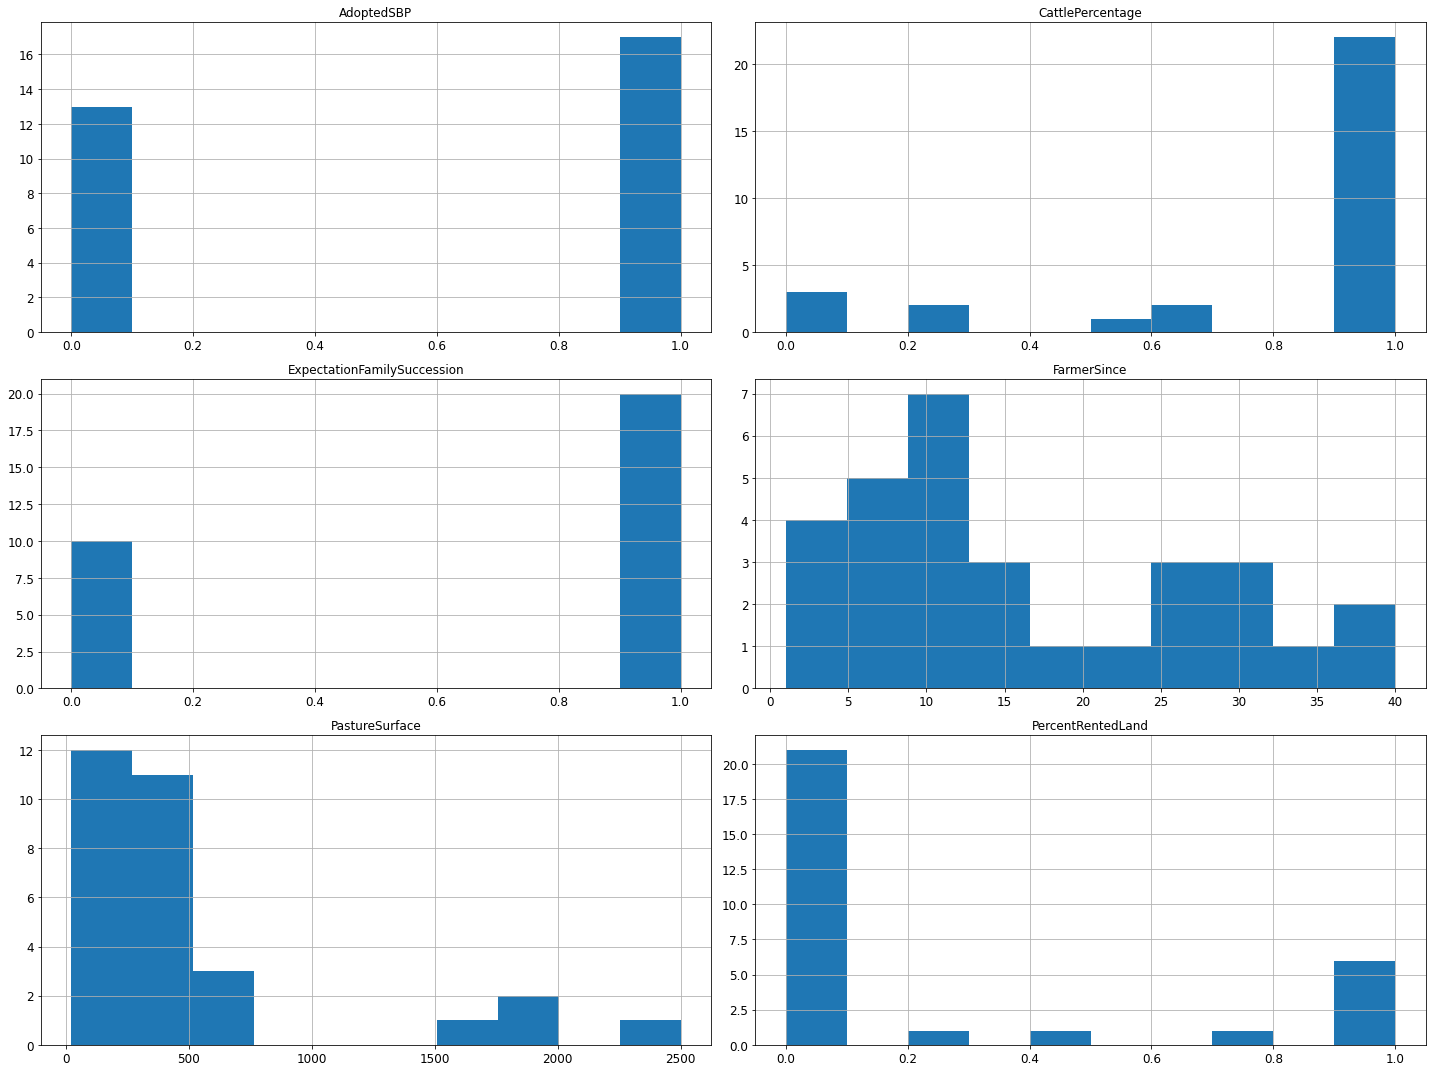

In [44]:
farms30.hist(figsize=(20,15))
save_fig('Numerical Attributes_Histograms')

#### Correlations

In [45]:
numerical_attributes = ['AdoptedSBP', 'PastureSurface', 'CattlePercentage', 'FarmerSince', 'PercentRentedLand', 'ExpectationFamilySuccession']

In [46]:
corr_matrix = farms30.corr()
corr_matrix

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,ExpectationFamilySuccession
AdoptedSBP,1.000000,0.157472,-0.044237,0.002577,-0.193404,0.095130
PastureSurface,0.157472,1.000000,-0.024826,-0.008405,-0.152965,0.059414
CattlePercentage,-0.044237,-0.024826,1.000000,-0.161004,0.124918,0.116587
FarmerSince,0.002577,-0.008405,-0.161004,1.000000,-0.404618,0.277121
PercentRentedLand,-0.193404,-0.152965,0.124918,-0.404618,1.000000,-0.089888
ExpectationFamilySuccession,0.095130,0.059414,0.116587,0.277121,-0.089888,1.000000


In [47]:
corr_matrix['AdoptedSBP'].sort_values(ascending=False)

AdoptedSBP                     1.000000
PastureSurface                 0.157472
ExpectationFamilySuccession    0.095130
FarmerSince                    0.002577
CattlePercentage              -0.044237
PercentRentedLand             -0.193404
Name: AdoptedSBP, dtype: float64

In [48]:
#from pandas.plotting import scatter_matrix

#scatter_matrix(farms30[['AdoptedSBP', 'PastureSurface', 'ExpectationFamilySuccession', 'PercentRentedLand']], figsize=(12, 12))
#save_fig('Numerical Attributes_Correlation Matrix')

### Analysis on CattlePercentage

In [49]:
farms30_cowbins = pd.DataFrame()
farms30_cowbins['AdoptedSBP'] = farms30['AdoptedSBP'].copy()
farms30_cowbins['CattlePercentage'] = pd.cut(farms30['CattlePercentage'],
                                             bins=[-np.inf,0.33,0.66,np.inf],
                                             labels=[1,2,3])

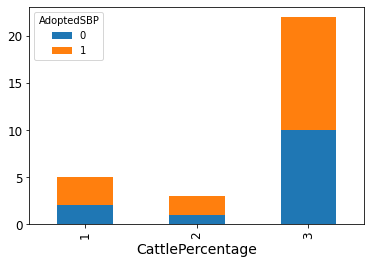

In [50]:
fig = farms30_cowbins.groupby('CattlePercentage')['AdoptedSBP'].value_counts().unstack().plot(kind='bar', stacked=True)

## Categorical attributes

In [51]:
categorical_attributes = ['Distrito', 'Concelho', 'LegalForm', 'HighestEducationalDegree', 
                          'HighestAgriculturalEducationalDegree', 'ExpectationFamilySuccession']

In [52]:
for cat_attr in categorical_attributes:
    print(farms30[cat_attr].value_counts())
    print("")

Évora         13
Beja           8
Setúbal        4
Portalegre     4
Santarém       1
Name: Distrito, dtype: int64

Montemor                6
Évora                   5
Beja                    2
Ferreira do Alentejo    1
Arronches               1
Grândola                1
Aljustrel               1
Arraiolos               1
Monforte                1
Alvito                  1
Ourique                 1
Portel                  1
Avis                    1
Castro Verde            1
Alcácer do Sal          1
Coruche                 1
Santiago do Cacém       1
Serpa                   1
Montijo                 1
Elvas                   1
Name: Concelho, dtype: int64

Sociedade Agrícola    20
Individual             8
Cooperativa Social     1
ENI                    1
Name: LegalForm, dtype: int64

Undergraduate    14
Graduate         13
Secondary         2
Primary           1
Name: HighestEducationalDegree, dtype: int64

Undergraduate    13
Graduate         11
None              6
Name: HighestAgric

Saving figure Categorical Attributes_Stacked Histograms


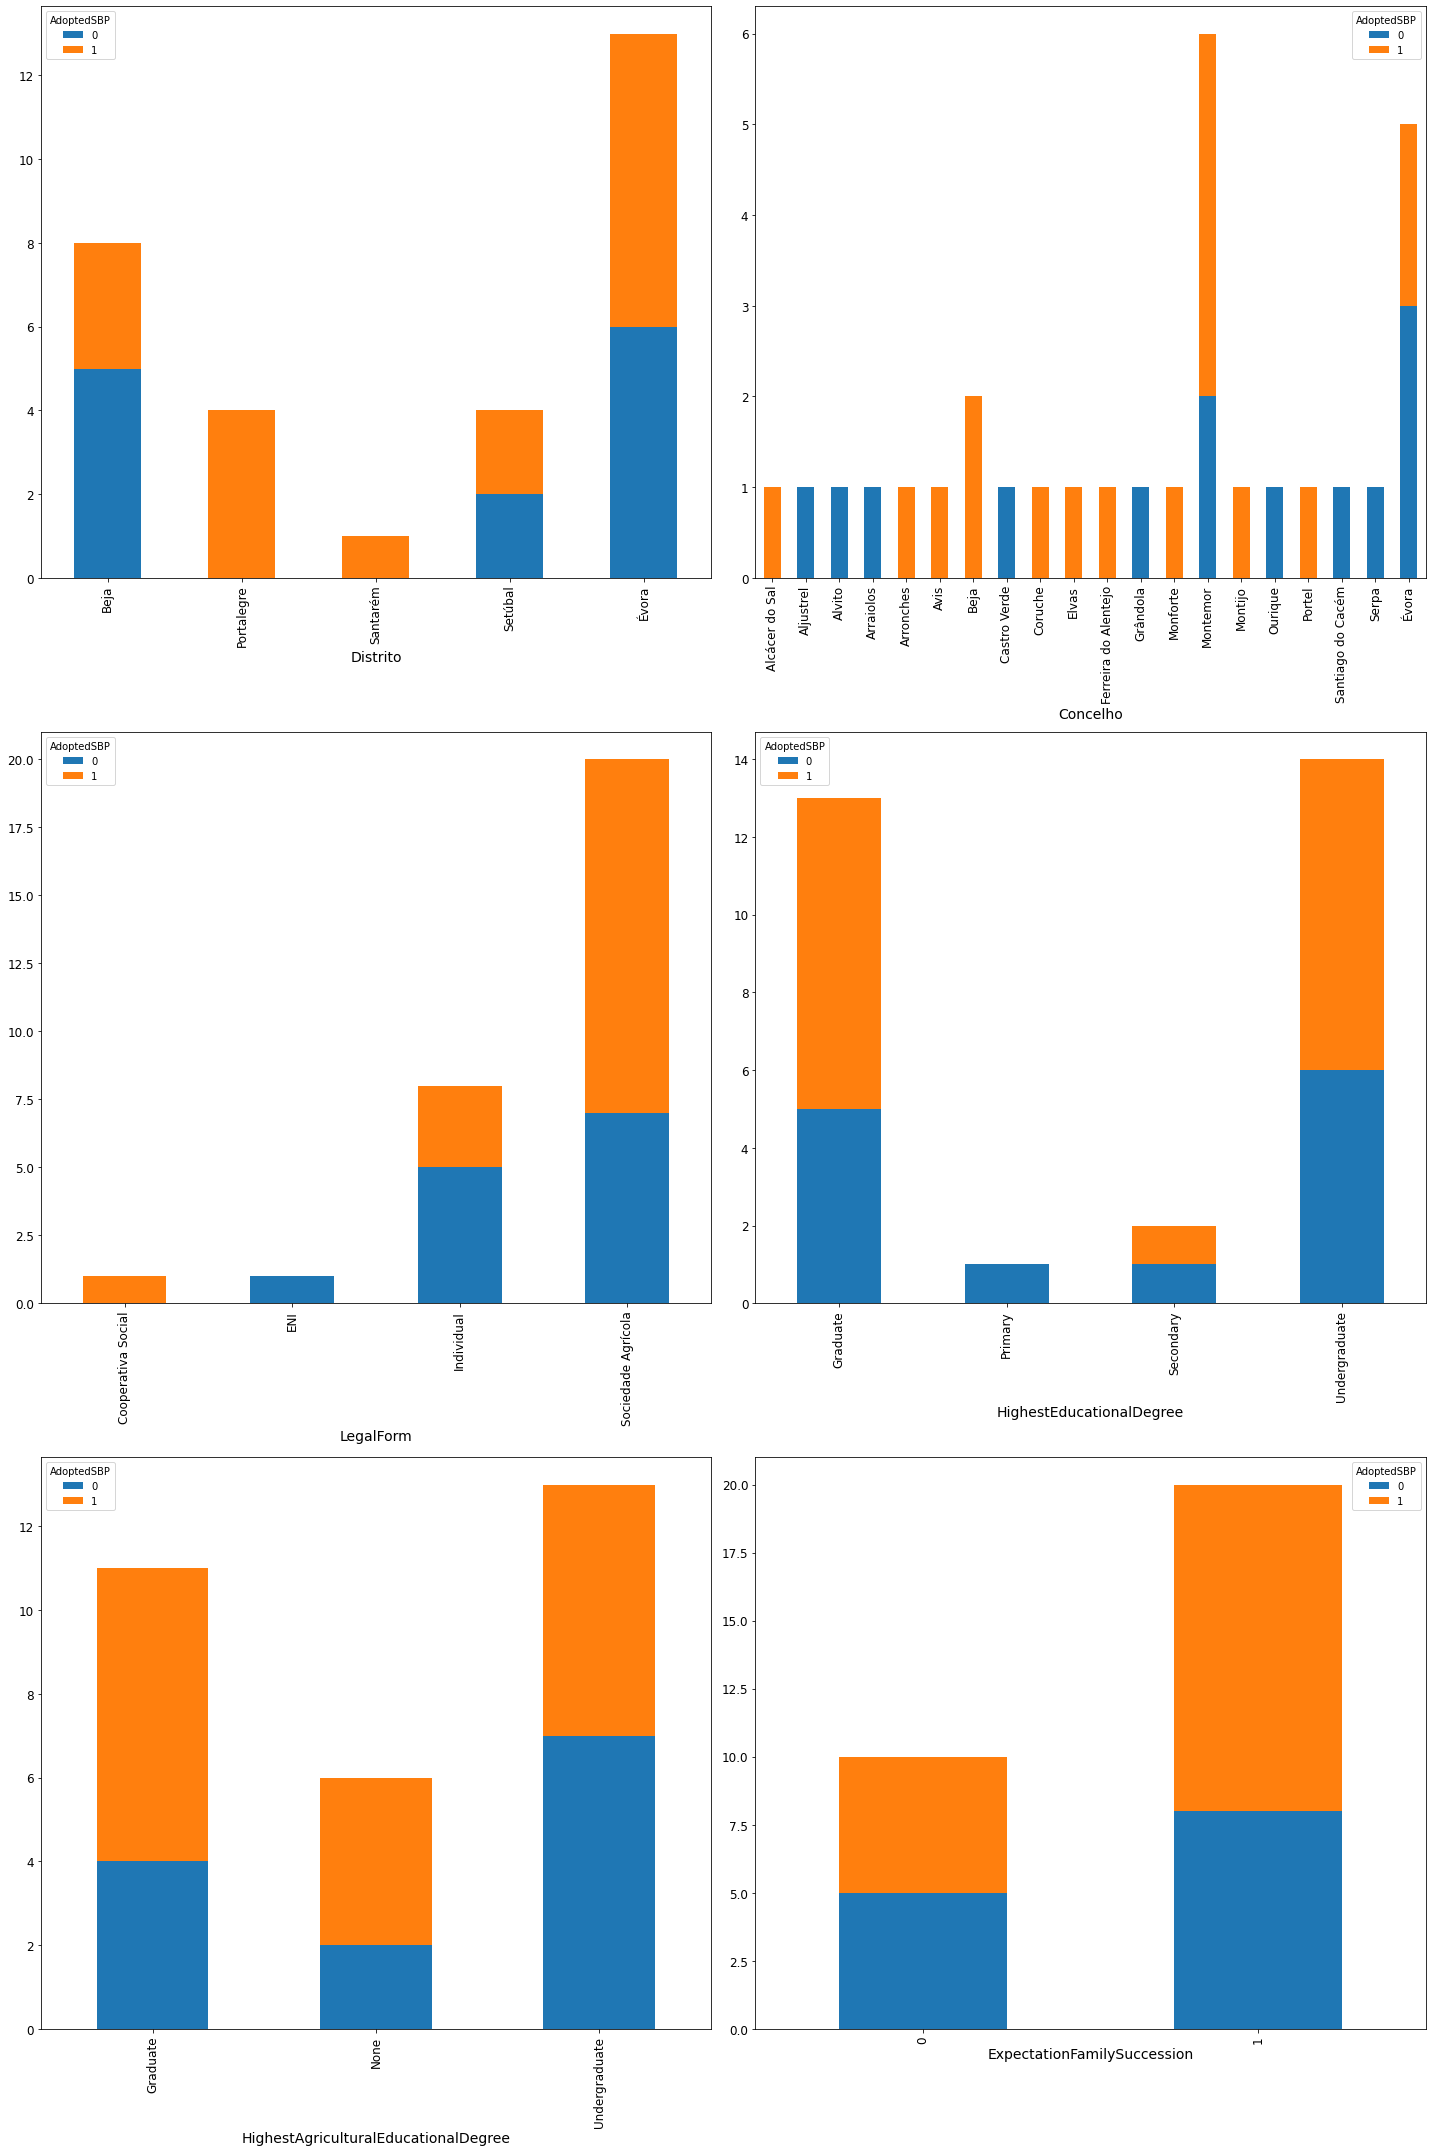

In [53]:
fig, axes = plt.subplots(math.ceil(len(categorical_attributes)/2), ncols=2, figsize=(20, 30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
axes = axes.flatten()
i = 0

for cat_attr in categorical_attributes:
    hist = farms30.groupby(cat_attr)['AdoptedSBP'].value_counts().unstack().plot(ax=axes[i], kind='bar', stacked=True)
    i += 1
    
save_fig('Categorical Attributes_Stacked Histograms')

### Analysis of categorical features with Chi-squared

### **NOTE**: results different than doing it manually with excel, for the right check version below with Scipy

In [54]:
farms_categoricals = farms30[categorical_attributes]
farms_categoricals.head()

,Distrito,Concelho,LegalForm,HighestEducationalDegree,HighestAgriculturalEducationalDegree,ExpectationFamilySuccession
FARM_ID,,,,,,
PT02,Setúbal,Grândola,Individual,Undergraduate,Undergraduate,1
PT13,Portalegre,Avis,Sociedade Agrícola,Undergraduate,Undergraduate,1
PT15,Portalegre,Monforte,Sociedade Agrícola,Undergraduate,Undergraduate,1
PT16,Évora,Évora,Individual,Undergraduate,Undergraduate,1
PT17,Évora,Montemor,Sociedade Agrícola,Undergraduate,None,1


In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

farms_labels = farms30['AdoptedSBP'].copy()

In [39]:
oe = OrdinalEncoder()
farms_categoricals_enc = oe.fit_transform(farms_categoricals)

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

In [41]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(farms_categoricals_enc, farms_labels)
for i in range(len(fs.scores_)):
    print('Feature {0:40}: {1:<40} {2:<40}'.format(categorical_attributes[i],fs.scores_[i], fs.pvalues_[i]))

Feature Distrito                                : 0.006464124111183026                     0.9359193044109877                      
Feature Concelho                                : 1.4533480134806724                       0.2279914942924309                      
Feature LegalForm                               : 0.09878356937180474                      0.7532943104678214                      
Feature HighestEducationalDegree                : 0.034754982189275                        0.8521100134498879                      
Feature HighestAgriculturalEducationalDegree    : 0.5791855203619907                       0.4466317481305161                      
Feature ExpectationFamilySuccession             : 0.0904977375565614                       0.7635453365378564                      


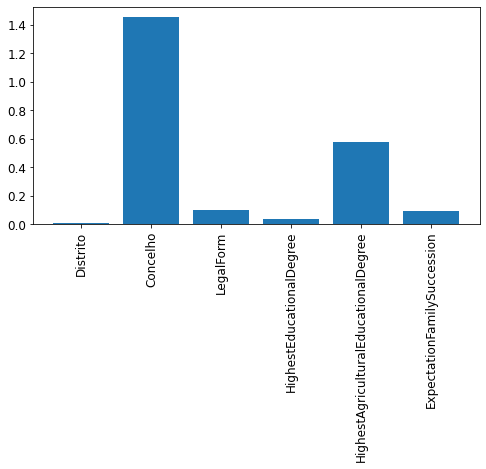

In [42]:
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.xticks([0, 1, 2, 3, 4, 5], categorical_attributes, rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(8, 4)
pyplot.show()

**Why such a high result for Concelho?** 
If we'd have 24 different Concelhos, 1 for each instance, and 12 adopters and 12 not, the expected value - with independent categories - for each cell would be: (1*12)/24 = 0.5. But 0.5 is not possible as label, it will always be 0 or 1 so we will have a high value of Chi2.

#### Chi-squared test with Scipy (same results as with Excel)

In [43]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [44]:
pd.crosstab(farms_labels,
                            farms_categoricals['LegalForm'],  
                            margins = False)

LegalForm,Cooperativa Social,ENI,Individual,Sociedade Agrícola
AdoptedSBP,,,,
0,0,1,5,7
1,1,0,3,13


In [45]:
def chi2_test(attribute):
    contingency_tab= pd.crosstab(farms_labels,
                                farms_categoricals[attribute],  
                                margins = False)
    stat, p, dof, expected = chi2_contingency(contingency_tab)
    # interpret p-value
    alpha = 0.05 # Significance value
    print('significance=%.3f, p=%.3f' % (alpha, p))
    print('chi2:', stat)
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    return p

In [46]:
p_values = []
for cat in categorical_attributes:
    print(cat)
    p_values.append(chi2_test(cat))
    print('')

Distrito
significance=0.050, p=0.274
chi2: 5.134876435781413
Independent (fail to reject H0)

Concelho
significance=0.050, p=0.414
chi2: 19.683257918552037
Independent (fail to reject H0)

LegalForm
significance=0.050, p=0.280
chi2: 3.8348416289592753
Independent (fail to reject H0)

HighestEducationalDegree
significance=0.050, p=0.689
chi2: 1.47083685545224
Independent (fail to reject H0)

HighestAgriculturalEducationalDegree
significance=0.050, p=0.592
chi2: 1.0470524950162956
Independent (fail to reject H0)

ExpectationFamilySuccession
significance=0.050, p=0.896
chi2: 0.016968325791855206
Independent (fail to reject H0)



In [47]:
p_values

[0.27373618477171296,
 0.4138592101306334,
 0.2798593927318363,
 0.6890173384117319,
 0.5924278132880957,
 0.8963587269811479]

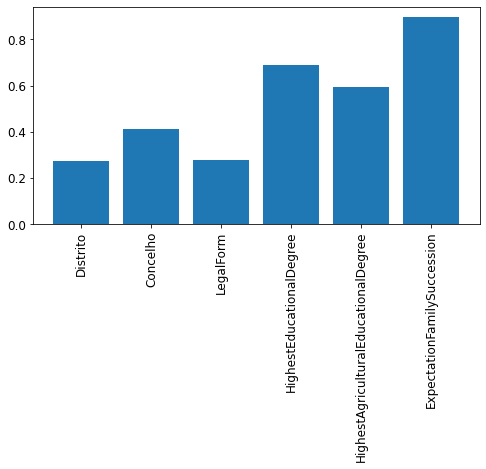

Saving figure p-values of adoption and categ. attribute are independent


<Figure size 432x288 with 0 Axes>

In [48]:
pyplot.bar([i for i in range(len(p_values))], p_values)
pyplot.xticks([0, 1, 2, 3, 4, 5], categorical_attributes, rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(8, 4)
pyplot.show()
save_fig('p-values of adoption and categ. attribute are independent')

**Rejected all the hypothesis of dependence**

# Drop unusable data

In [49]:
farms30_selected = farms30.drop('Concelho', axis=1) # Too many with too few instances each. Distrito is better
farms30_selected = farms30.drop('HighestAgriculturalEducationalDegree', axis=1) # Redundant with HighestEducationalDegree

## Splitting the data

**Improvement**: performe stratified sampling

In [50]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(farms30_selected, test_size=0.2, random_state=42)

## Data preparation

In [51]:
farms = train_set.drop('AdoptedSBP', axis=1)
farms_labels = train_set['AdoptedSBP'].copy()

### Handling categorical attributes

#### Ordinal econding

In [52]:
farms_ordinal_attributes = ['HighestEducationalDegree']
farms_ordinal_cat = farms[farms_ordinal_attributes]
farms_ordinal_cat[:5]

,HighestEducationalDegree
FARM_ID,
PT42,Undergraduate
PT38,Undergraduate
PT25,Primary
PT02,Undergraduate
PT17,Undergraduate


In [53]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=[['Primary', 'Secondary', 'Undergraduate', 'Graduate']])
farms_ordinal_cat_encoded = ordinal_encoder.fit_transform(farms_ordinal_cat)

farms_ordinal_cat_encoded[:5]

array([[2.],
       [2.],
       [0.],
       [2.],
       [2.]])

#### One-hot encoding

In [54]:
farms_onehot_attributes = ['Distrito', 'LegalForm']
farms_onehot_cat = farms[farms_onehot_attributes]

farms_onehot_cat.head()

,Distrito,LegalForm
FARM_ID,,
PT42,Setúbal,Sociedade Agrícola
PT38,Évora,Sociedade Agrícola
PT25,Beja,Individual
PT02,Setúbal,Individual
PT17,Évora,Sociedade Agrícola


In [55]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
farms_onehot_cat_encoded = onehot_encoder.fit_transform(farms_onehot_cat)

farms_onehot_cat_encoded.toarray()

array([[0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1.

In [56]:
onehot_encoder.categories_

[array(['Beja', 'Portalegre', 'Santarém', 'Setúbal', 'Évora'], dtype=object),
 array(['Cooperativa Social', 'ENI', 'Individual', 'Sociedade Agrícola'],
       dtype=object)]

### Preparation pipeline

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [58]:
[attr for attr in numerical_attributes if attr != 'AdoptedSBP']

['PastureSurface',
 'CattlePercentage',
 'FarmerSince',
 'PercentRentedLand',
 'ExpectationFamilySuccession']

In [59]:
preparation_pipeline = ColumnTransformer([
    ('num', StandardScaler(), [attr for attr in numerical_attributes if attr != 'AdoptedSBP']),
    ('ord_cat', ordinal_encoder, farms_ordinal_attributes),
    ('onehot_cat', onehot_encoder, farms_onehot_attributes)
])

In [60]:
farms_prepared = preparation_pipeline.fit_transform(farms)

In [61]:
# Print prepared data as a DataFrame
attributes = [attr for attr in numerical_attributes if attr != 'AdoptedSBP'] + farms_ordinal_attributes
for cat_name in onehot_encoder.categories_:
    attributes += cat_name.tolist()   
pd.DataFrame(farms_prepared, columns=attributes, index=farms.index).head()

,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,ExpectationFamilySuccession,HighestEducationalDegree,Beja,Portalegre,Santarém,Setúbal,Évora,Cooperativa Social,ENI,Individual,Sociedade Agrícola
FARM_ID,,,,,,,,,,,,,,,
PT42,-0.345130,-0.430043,1.563341,-0.612880,-1.290994,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
PT38,-0.204910,0.647537,-0.609320,-0.612880,-1.290994,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
PT25,-0.638358,0.647537,-0.776448,1.816889,-1.290994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
PT02,-0.280715,-2.085207,0.978394,-0.612880,0.774597,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
PT17,-0.502298,0.647537,-0.609320,1.816889,0.774597,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Train model

In [62]:
from sklearn.linear_model import LogisticRegression

logit_regr = LogisticRegression()
logit_regr.fit(farms_prepared, farms_labels)

LogisticRegression()

In [63]:
some_data = farms_prepared[:5]
some_labels = farms_labels.iloc[:5]
print('Predict:', logit_regr.predict(some_data))
print('Labels:', some_labels)

Predict: [1 1 0 1 0]
Labels: FARM_ID
PT42    1
PT38    0
PT25    0
PT02    0
PT17    1
Name: AdoptedSBP, dtype: int32


### Logit regression with l2 regul

In [64]:
farms_prepared.shape

(24, 15)

In [65]:
from sklearn.model_selection import cross_val_score

cross_val_score(logit_regr, farms_prepared, farms_labels, scoring='accuracy', cv=4)

array([0.33333333, 0.33333333, 0.66666667, 0.33333333])

In [66]:
for attr, coef in zip(attributes, logit_regr.coef_.tolist()[0]):
    print(coef, attr)

-0.040998020790186766 PastureSurface
-0.28561441266131393 CattlePercentage
-0.28826996898521623 FarmerSince
-0.48606763629712313 PercentRentedLand
0.30186416338287947 ExpectationFamilySuccession
-0.0547999380653788 HighestEducationalDegree
-0.7115856105941215 Beja
0.8155048059270821 Portalegre
0.19584429855552257 Santarém
-0.0995142450689616 Setúbal
-0.20024673797790862 Évora
0.3747816827294384 Cooperativa Social
-0.2590614748617053 ENI
-0.6051999108165419 Individual
0.4894822137904213 Sociedade Agrícola


### Logit regression with l1 regul

In [67]:
logit_regr_l1 = LogisticRegression(penalty='l1', solver='liblinear')
cross_val_score(logit_regr_l1, farms_prepared, farms_labels, scoring='accuracy', cv=4)

array([0.16666667, 0.16666667, 0.66666667, 0.33333333])

In [68]:
logit_regr_l1.fit(farms_prepared, farms_labels)

LogisticRegression(penalty='l1', solver='liblinear')

In [69]:
for attr, coef in zip(attributes, logit_regr_l1.coef_.tolist()[0]):
    print(coef, attr)

0.0 PastureSurface
-0.11996715326829342 CattlePercentage
0.0 FarmerSince
-0.28832921817212764 PercentRentedLand
0.01692532012867528 ExpectationFamilySuccession
0.0 HighestEducationalDegree
-0.38328083062074864 Beja
0.9522426601536368 Portalegre
0.0 Santarém
0.0 Setúbal
0.0 Évora
0.0 Cooperativa Social
0.0 ENI
-0.16118295299961977 Individual
0.24189242277048167 Sociedade Agrícola


### Evalutation through precision and recall

In [70]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [71]:
predict_l2 = cross_val_predict(logit_regr, farms_prepared, farms_labels, cv=3)
confusion_matrix(farms_labels, predict_l2)

array([[5, 6],
       [8, 5]], dtype=int64)

In [72]:
print('Precision:', precision_score(farms_labels, predict_l2))
print('Recall:', recall_score(farms_labels, predict_l2))
print('F1 score:', f1_score(farms_labels, predict_l2))

Precision: 0.45454545454545453
Recall: 0.38461538461538464
F1 score: 0.41666666666666663


## Results analysis

**Observations on results**: 
* The results are really bad.
* Some things really do not make sense, as the negative and really low score for the PastureSurface
* The coefficients are all pretty close with the l2.
* The l1 performs worse, but also maybe beacuse give a lot of importance to the belonging of one municipality

**The results on the coefficients from the lasso regularization should not be considered, since the performance is really bad!**

**Possible errors**:
* Using each municipality separately like this make sense? Probably yes actually


# Second analysis on 30 farmers

Let's try to reduce the features to:
* PastureSurface: exhibited high correlation and should be linked with NPV (for this reason could also be taken away)
* PercenRentedLand: highest correlation (negative) and still a high weight in l1 regularization 
* HighestEducationalDegree: used in the theoretical model (to check if the Agricultural one would be better)
* LegalForm --> Individual farming or part of a community: looked interesting from the graph, to check theoretically if it would make sense


* To add inter and intra municipality adoption when available, for the moment municipality not considered

Removed:
* CattlePercentage: looking at the graph, it looks irrelevant for the data we have
* FarmerSince: also beacuse it has the problem of farmers from less than 10 years, so after adoption, that could have inherited and so should have counted as older farmers
* ExpectationFamilySuccession: looking at the graph, no difference if expected or not

### Transform LegalForm

Tranform it into a binary category, 1 if part of a cooperative/association (including ENI) and 0 if individual

In [73]:
mapping = {'Cooperativa Social': 1, 'ENI': 1, 'Sociedade Agrícola': 1, 'Individual': 0}
general_data_2 = general_data[['PercentRentedLand']]
general_data_2['LegalForm'] = general_data.loc[:, 'LegalForm'].replace(mapping)
general_data_2.head()

c:\users\giaco\.virtualenvs\mixed-abm-phbhzcqt\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PercentRentedLand,LegalForm
FARM_ID,,
PT02,0.0,0
PT13,0.0,1
PT15,1.0,1
PT16,1.0,0
PT17,1.0,1


### Create new dataset

In [74]:
education_data.head()

,HighestEducationalDegree,HighestAgriculturalEducationalDegree
FARM_ID,,
PT02,Undergraduate,Undergraduate
PT13,Undergraduate,Undergraduate
PT15,Undergraduate,Undergraduate
PT16,Undergraduate,Undergraduate
PT17,Undergraduate,None


In [75]:
degree = 'HighestEducationalDegree' #To change between the two educational degrees

In [76]:
farms_dataframes = [area_data, general_data_2, education_data[[degree]]]
farms30_2 = functools.reduce(lambda left, right: pd.merge(left, right, on='FARM_ID'), farms_dataframes)

farms30_2.head()

,AdoptedSBP,PastureSurface,PercentRentedLand,LegalForm,HighestEducationalDegree
FARM_ID,,,,,
PT02,0,364.00,0.0,0,Undergraduate
PT13,1,542.58,0.0,1,Undergraduate
PT15,1,262.70,1.0,1,Undergraduate
PT16,0,23.00,1.0,0,Undergraduate
PT17,1,250.00,1.0,1,Undergraduate


In [77]:
train_set_2, test_set_2 = train_test_split(farms30_2, test_size=0.2, random_state=42)

In [78]:
farms_2 = train_set_2.drop('AdoptedSBP', axis=1)
farms_2_labels = train_set_2['AdoptedSBP'].copy()

### Transformation pipeline

In [79]:
farms_ordinal_attributes_2 = ['HighestEducationalDegree']
numerical_attributes_2 = ['PastureSurface', 'PercentRentedLand', 'LegalForm']

attributes_2 = farms_ordinal_attributes_2 + numerical_attributes_2

In [80]:
preparation_pipeline_2 = ColumnTransformer([
    ('num', StandardScaler(), numerical_attributes_2),
    ('ord_cat', ordinal_encoder, farms_ordinal_attributes),
])

In [81]:
farms_2_prepared = preparation_pipeline_2.fit_transform(farms_2)

### Implement logistic regression

#### L2 regularizer

In [82]:
logit_regr_2_l2 = LogisticRegression()
cross_val_score(logit_regr_2_l2, farms_2_prepared, farms_2_labels, scoring='accuracy', cv=3)

array([0.75 , 0.625, 0.375])

In [83]:
logit_regr_2_l2.fit(farms_2_prepared, farms_2_labels)
for attr, coef in zip(attributes_2, logit_regr_2_l2.coef_.tolist()[0]):
    print(coef, attr)

-0.02421634669125458 HighestEducationalDegree
-0.33335086800442904 PastureSurface
0.5783969230212468 PercentRentedLand
0.04083746046800632 LegalForm


In [84]:
logit_regr_2_l1 = LogisticRegression(penalty='l1', solver='liblinear')
cross_val_score(logit_regr_2_l1, farms_2_prepared, farms_2_labels, scoring='accuracy', cv=3)

array([0.625, 0.625, 0.375])

In [85]:
logit_regr_2_l1.fit(farms_2_prepared, farms_2_labels)
for attr, coef in zip(attributes_2, logit_regr_2_l1.coef_.tolist()[0]):
    print(coef, attr)

0.0 HighestEducationalDegree
-0.2159014307363287 PastureSurface
0.5051693107113515 PercentRentedLand
0.04231997573145819 LegalForm


### Evalutation through precision and recall

In [86]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [87]:
predict_l2 = cross_val_predict(logit_regr_2_l2, farms_2_prepared, farms_2_labels, cv=3)
confusion_matrix(farms_2_labels, predict_l2)

array([[ 4,  7],
       [ 3, 10]], dtype=int64)

In [88]:
print('Precision:', precision_score(farms_2_labels, predict_l2))
print('Recall:', recall_score(farms_2_labels, predict_l2))
print('F1 score:', f1_score(farms_2_labels, predict_l2))

Precision: 0.5882352941176471
Recall: 0.7692307692307693
F1 score: 0.6666666666666667


In [89]:
predict_l1 = cross_val_predict(logit_regr_2_l1, farms_2_prepared, farms_2_labels, cv=3)
confusion_matrix(farms_2_labels, predict_l1)

array([[ 3,  8],
       [ 3, 10]], dtype=int64)

In [90]:
print('Precision:', precision_score(farms_2_labels, predict_l1))
print('Recall:', recall_score(farms_2_labels, predict_l1))
print('F1 score:', f1_score(farms_2_labels, predict_l1))

Precision: 0.5555555555555556
Recall: 0.7692307692307693
F1 score: 0.6451612903225806


* Main problem: many false positives (low precision)

# Conclusions

* The dataset is not enough to do machine learning by itself. Still have to try to insert the NPV as a feature, but very unlikely that it will improve enough to be used)
* Results on feature selection:
> * The most interesting thing is the relevance of the PercentRentedLand. However, it has a negative correlation and a negative score in the regression with all the variables that makes sense, while in the regression with fewer features it has a positive score that does not really make sense.

# Export excel file for toy model

In [38]:
farms30_toymodel_init = pd.DataFrame()
farms30_toymodel_init['PastureSurface'] = farms30['PastureSurface'].copy()
farms30_toymodel_init['Pasture'] = 'Natural Pasture'

In [39]:
farms30_toymodel_init.head()

,PastureSurface,Pasture
FARM_ID,,
PT02,364.00,Natural Pasture
PT13,542.58,Natural Pasture
PT15,262.70,Natural Pasture
PT16,23.00,Natural Pasture
PT17,250.00,Natural Pasture


In [40]:
path_init = '../toy-abm/sbp-toy-abm/data/FarmsData.xlsx'
farms30_toymodel_init.to_excel(path_init)

In [41]:
farms30_valid = pd.DataFrame()
farms30_valid['Pasture'] = farms30['AdoptedSBP'].replace({1: 'Sown Permanent Pasture', 0: 'Natural Pasture'})

In [42]:
farms30_valid.head()

,Pasture
FARM_ID,
PT02,Natural Pasture
PT13,Sown Permanent Pasture
PT15,Sown Permanent Pasture
PT16,Natural Pasture
PT17,Sown Permanent Pasture


In [43]:
path_valid = '../toy-abm/sbp-toy-abm/data/FarmsDataValidation.xlsx'
farms30_valid.to_excel(path_valid)